# Household Poverty Level Prediction
## Part 1. EDA

## Loading libraries and data

In [54]:

import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style = 'darkgrid') #


import os
from pylab import rcParams
rcParams['figure.figsize'] = 25, 12.5
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


## Primary EDA

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


We can conclude, that most of the variables have types of float and integers. Only 5 columns are objects, let's explore which ones

In [56]:
categorical = []
numerical = []
for feature in test.columns:
    if test[feature].dtype == object:
        categorical.append(feature)
    else:
        numerical.append(feature)
train[categorical].head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


So, we have 2 ID columns, the other 3 columns can be converted into integers. Intuitively, "no" can be converted to 0, while "yes" to 1. But for now we won't do that

Let's explore NA values in data

In [57]:
train[numerical].isnull().sum().sort_values(ascending = False).head(8)

rez_esc           7928
v18q1             7342
v2a1              6860
meaneduc             5
SQBmeaned            5
v14a                 0
refrig               0
techoentrepiso       0
dtype: int64

We can actually conclude, that our data is pretty full, only in 5 columns we have observe Missing values. For now it's too early to make conclusion about dropping out first three colums as useful information may be contained there(We will explore the hypothesis using graphs). Moreover, LightGBM and XGBoost are able to handle missing values while training, so that's not a problem.

We can fill in NAs with mean or median values for the rest 2 cols.

In [58]:
test[numerical].isnull().sum().sort_values(ascending = False).head(8)

rez_esc           19653
v18q1             18126
v2a1              17403
meaneduc             31
SQBmeaned            31
v14a                  0
refrig                0
techoentrepiso        0
dtype: int64

Good news is that the same columns with missing values are observed in test! The good thing is to check if we should fill in NAs with mean or median values.

In [59]:
train[['meaneduc', 'SQBmeaned']].describe()

,meaneduc,SQBmeaned
count,9552.000000,9552.000000
mean,9.231523,102.588867
std,4.167694,93.516890
min,0.000000,0.000000
25%,6.000000,36.000000
50%,9.000000,81.000000
75%,11.600000,134.560010
max,37.000000,1369.000000


The point is that if we observe outliers in data, we should fill in NAs with median, otherwise it's ok to fill in with mean values. In the table, 50% is the median value, mean is mean :) Here it's fine to use mean values

In [60]:
train['meaneduc'].fillna(train['meaneduc'].mean(), inplace = True)
train['SQBmeaned'].fillna(train['SQBmeaned'].mean(), inplace = True)
#the same for test
test['meaneduc'].fillna(test['meaneduc'].mean(), inplace = True)
test['SQBmeaned'].fillna(test['SQBmeaned'].mean(), inplace = True)
train['rez_esc'].fillna(0, inplace = True)
train['v18q1'].fillna(0, inplace = True)
train['v2a1'].fillna(0, inplace = True)

Other 3 columns we fill in with 0's temporarily

## Seaborn

Seaborn is a great library for visualization. You can choose many palettes, which makes the graphs visually nice. For instance, some of them.

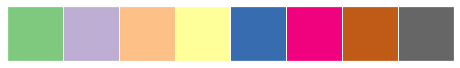

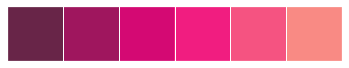

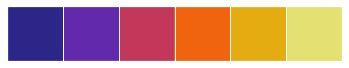

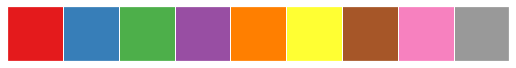

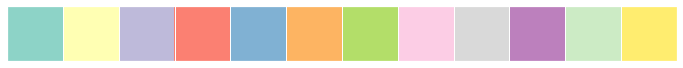

In [61]:
sns.set(style = 'darkgrid')
sns_plot = sns.palplot(sns.color_palette('Accent'))
sns_plot = sns.palplot(sns.color_palette('Accent_d'))
sns_plot = sns.palplot(sns.color_palette('CMRmap'))
sns_plot = sns.palplot(sns.color_palette('Set1'))
sns_plot = sns.palplot(sns.color_palette('Set3'))

In [62]:
target_values = train['Target'].value_counts()
target_values = pd.DataFrame(target_values)
target_values['Household_type'] = target_values.index
target_values

,Target,Household_type
4,5996,4
2,1597,2
3,1209,3
1,755,1


Let's map index


In [63]:
mappy = {4: "NonVulnerable", 3: "Moderate Poverty", 2: "Vulnerable", 1: "Extereme Poverty"}
target_values['Household_type'] = target_values.Household_type.map(mappy)
target_values

,Target,Household_type
4,5996,NonVulnerable
2,1597,Vulnerable
3,1209,Moderate Poverty
1,755,Extereme Poverty


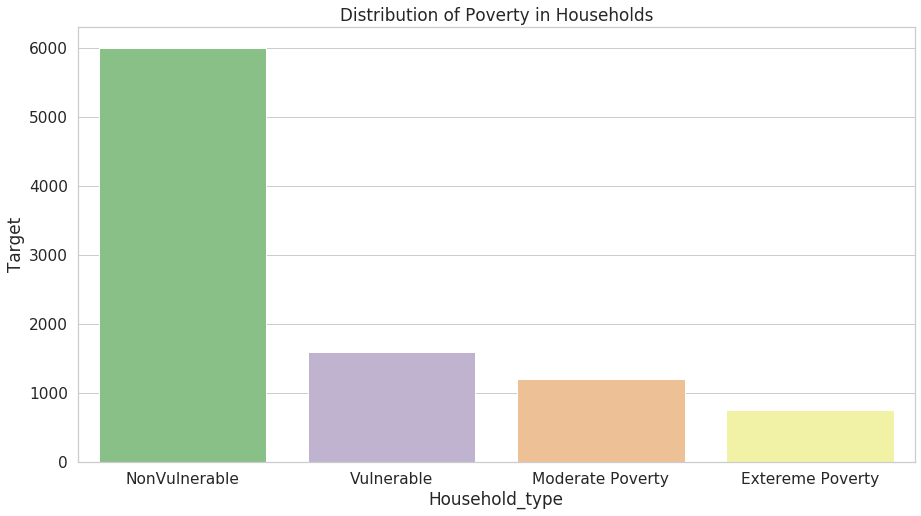

In [64]:
sns.set(style = 'whitegrid', font_scale=1.4)
fig = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x = 'Household_type', y = 'Target', data = target_values, palette='Accent', ci = None).set_title('Distribution of Poverty in Households')

As an 'insight', we can claim that classes are skewed. And, probably, without any effort our algorithms will have large errors predicting Extreme Powerty.

## Correlations

In [65]:
#Let's find out largest correlations and depict them
corrs = train.corr().abs()
corrs1 = corrs.unstack().drop_duplicates()
strongest = corrs1.sort_values(kind="quicksort", ascending = False)
strongest1 = pd.DataFrame(strongest)
temp = strongest1.index.values
first_cols = [i[0] for i in temp]
second_cols = [j[1] for j in temp]
total_cols_corr = list(set(first_cols[:20] + second_cols[:20]))
strongest.head(25)

v2a1             v2a1               1.000000
r4t3             tamhog             0.998107
public           coopele            0.979824
age              SQBage             0.958090
tamhog           SQBhogar_total     0.950173
r4t3             SQBhogar_total     0.948761
meaneduc         SQBmeaned          0.948003
abastaguadentro  abastaguafuera     0.946470
r4t3             tamviv             0.945243
overcrowding     SQBovercrowding    0.945094
tamhog           tamviv             0.943640
escolari         SQBescolari        0.943325
sanitario2       sanitario3         0.939439
tamviv           SQBhogar_total     0.901396
energcocinar2    energcocinar3      0.901042
hogar_nin        SQBhogar_nin       0.884141
v18q             v18q1              0.849916
elimbasu1        elimbasu3          0.833666
r4h2             r4h3               0.821367
r4m2             r4m3               0.820109
r4t2             r4t3               0.806381
                 hogar_adul         0.805526
pisomoscer

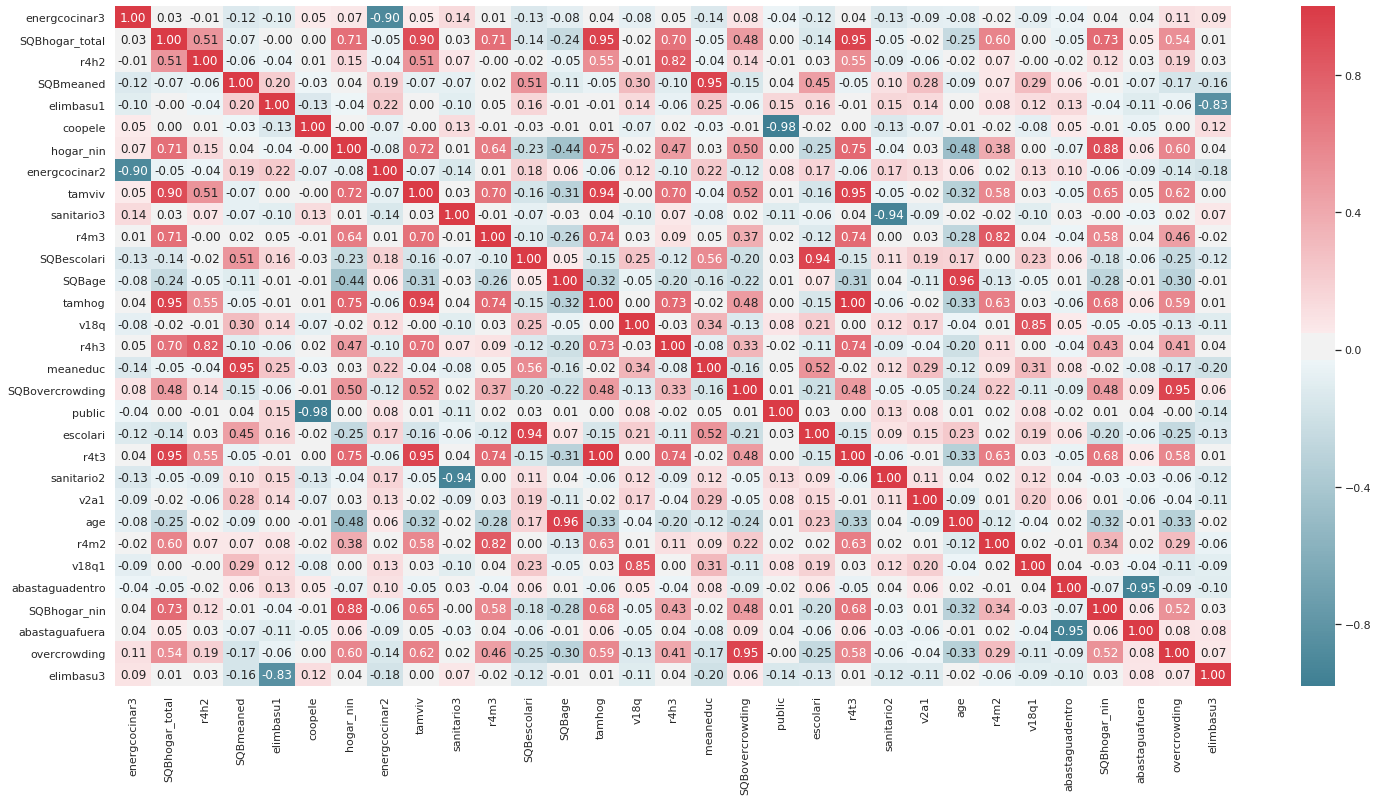

In [66]:
corr = train[total_cols_corr].corr()
sns.set(font_scale=1)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(25, 12.5))
sns.heatmap(corr, cmap=cmap, annot=True, ax=ax, fmt='.2f')

As a result, we might probably delete some columns without decreasing ROC as they are collinear( for instance, public, "=1 electricity from CNFL,  ICE,  ESPH/JASEC" and coopele, =1 electricity from cooperative, correlation between these two is -.98) 


/home/kumar/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


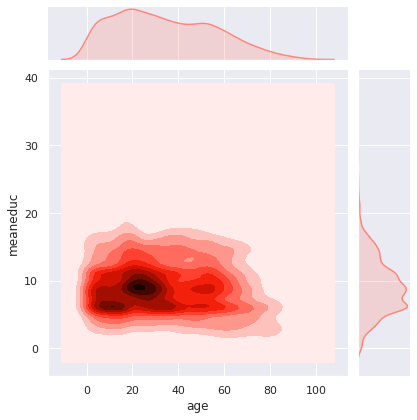

In [67]:
train['v2a11'] = train.v2a1.apply(lambda x: np.log(x+1))
sns.set(font_scale=1, style="darkgrid")
c =  sns.color_palette('spring_d')[4]
sns_jointplot = sns.jointplot('age', 'meaneduc', data=train, kind='kde', color=c, size=6)

Most of train data is allocated around the age of 20 and mean education of 10 years.
But we didn't separate data by *Target*.
Let's do that too.

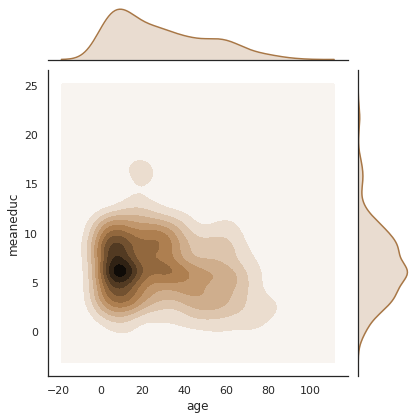

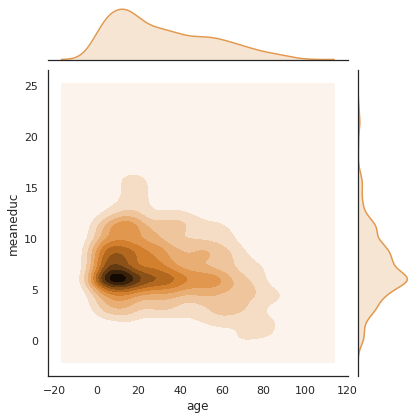

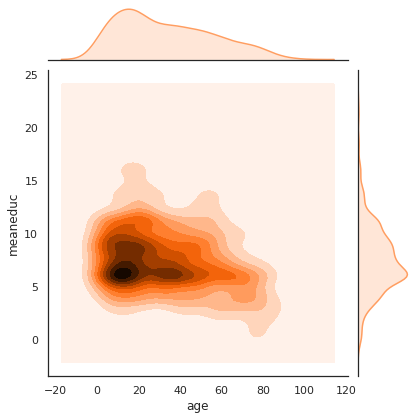

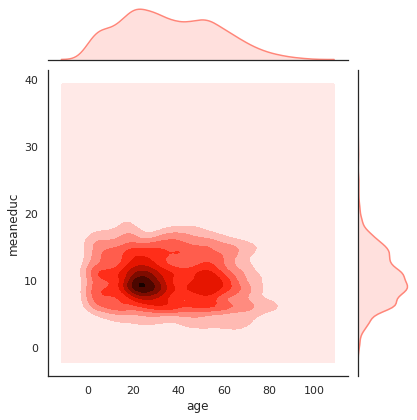

In [68]:
for i in range(1, 5):
    sns.set(font_scale=1, style="white")
    c =  sns.color_palette('spring_d')[i]
    sns_jointplot = sns.jointplot('age', 'meaneduc', data=train[train['Target'] == i], kind='kde', color=c, size=6, stat_func=None)

The picture became much better. For NonVulnerables both mean years of education and age are higher and allocates around 10 and 20 respectively. It's useful to mention that variance of mean education for NonVulnerables is less than for others.

For Extreme Poors age in years is the least among these 4 categories.

### Living condition comparisons

Let's check out some of the living conditions for different households

In [69]:
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (0, df[var].max()))
    facet.add_legend()
    plt.show()

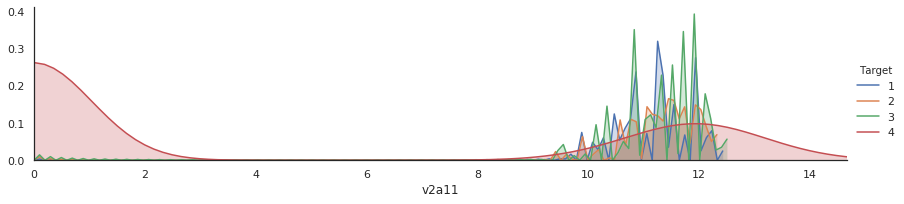

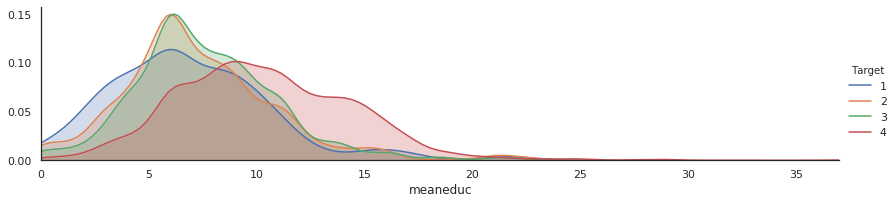

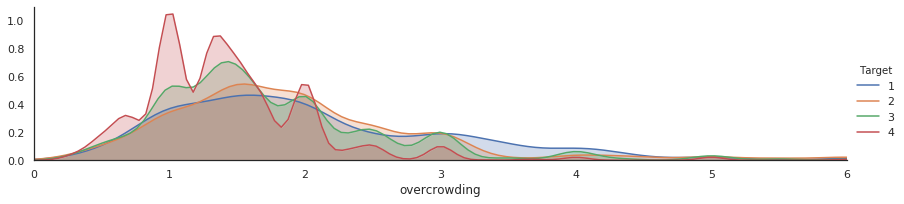

In [70]:
#select some columns
numerical1 = ['v2a11', 'meaneduc', 'overcrowding'] #monthly pay rent, mean education, overcrowd
for numy in numerical1:
    plot_distribution(train, numy, 'Target')
#In the first graph instead of 0's should be nulls(we changed these before). So there is no info about monthly rate payment for non vulnerable households 

Text(0.5, 1.0, 'Number of men in households')

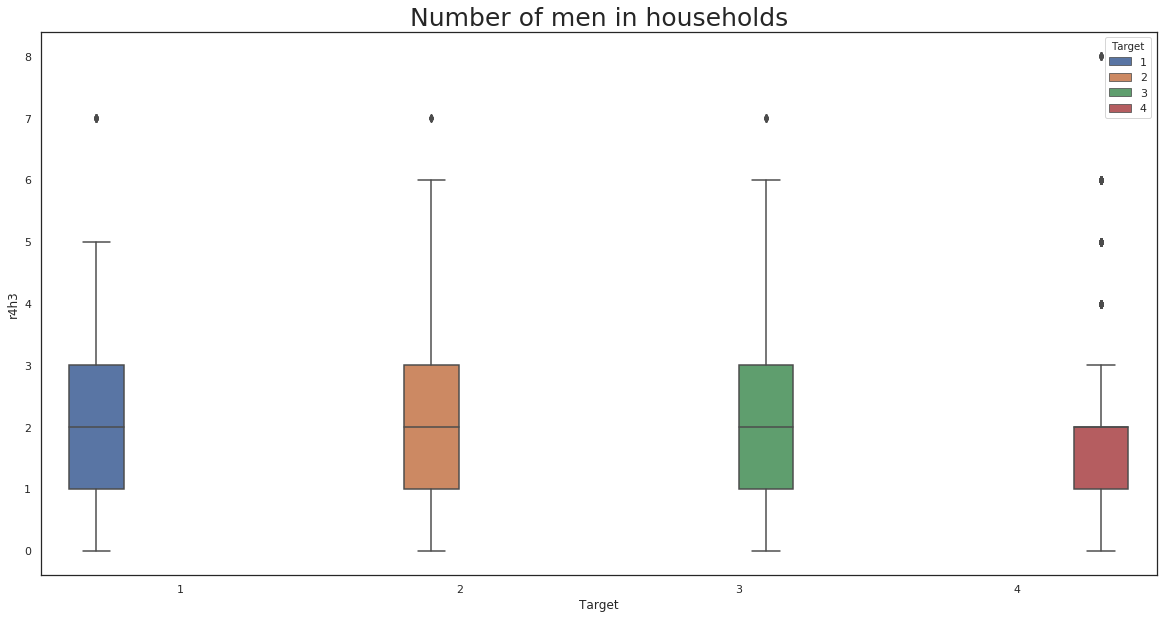

In [71]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='Target', y = 'r4h3',ax = ax, data = train, hue = 'Target' )
ax.set_title('Number of men in households', size = 25)

Text(0.5, 1.0, 'Number of women in households')

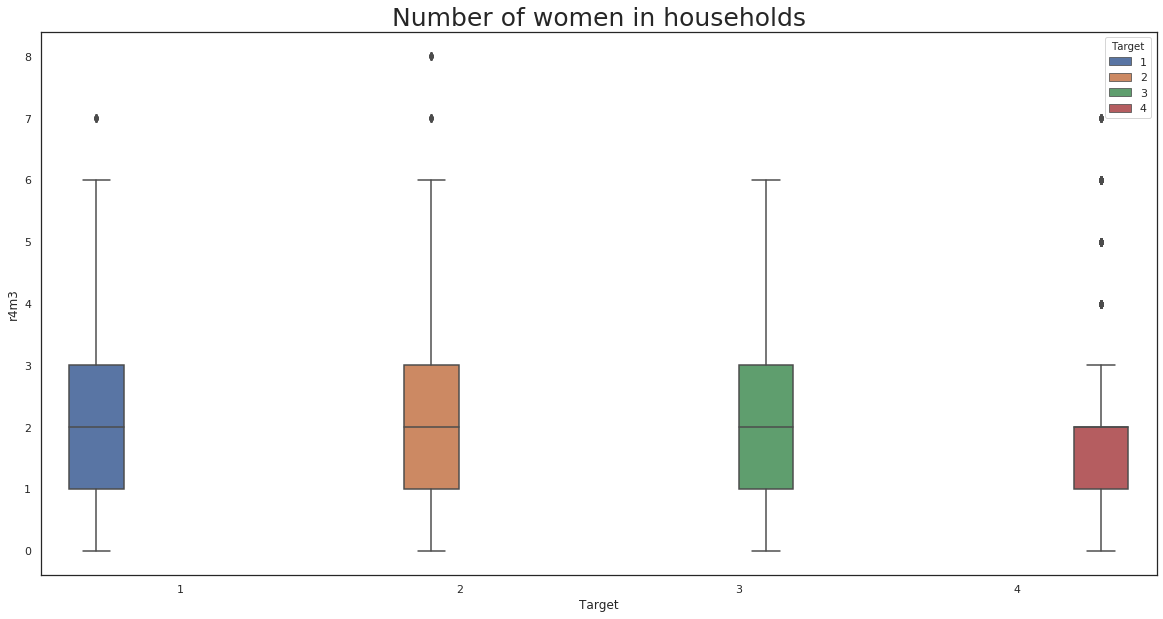

In [72]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='Target', y = 'r4m3',ax = ax, data = train, hue = 'Target' )
ax.set_title('Number of women in households', size = 25)

The Numbers are close to each other between categories. Probably, these two variables(number of women and men in the household) won't have a large impact on target variable.

Let's also check the hypothesis that Poorer households have more children

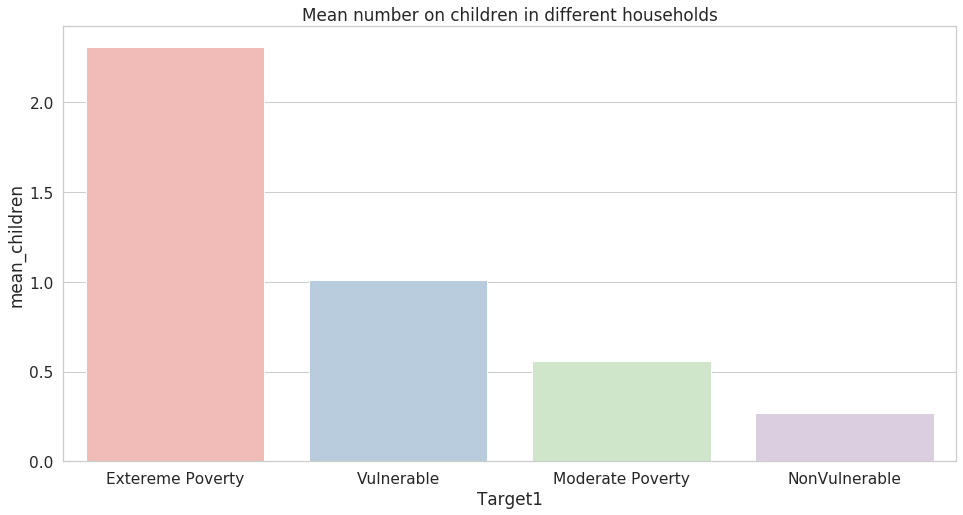

In [73]:
ninos = train.groupby(by = 'Target')['hogar_nin', 'Target'].sum()
ninos = pd.DataFrame(ninos)
ninos['mean_children'] = (ninos['hogar_nin']/ninos['Target'])
ninos['Target1'] = ninos.index.map({4: "NonVulnerable", 3: "Moderate Poverty", 2: "Vulnerable", 1: "Extereme Poverty"})
sns.set(style = 'whitegrid', font_scale=1.4)
fig = plt.subplots(figsize=(16, 8))
ax = sns.barplot(x = 'Target1', y = 'mean_children', data = ninos, palette='Pastel1', ci = None).set_title('Mean number on children in different households')

We can observe a huge difference in mean number of children in different types of households, consequently, the hypothesis about the mean number of children in poor households is true. Therefore,  we can create this feature in our data to increase score.

We explored that Extreme poverty households tend to have more children than nonVulnerables. Let's dig deeper and find out how monthly rate payment per person differ. 
Firstly, as we have observed a lot of missing values in v2a1(Monthly rent payment),so necessary to say that there will be high bias. 

In [74]:
train['v2a1'].replace(0, np.nan, inplace = True)
train["v2a1"] = train.groupby("Target").transform(lambda x: x.fillna(x.median()))
rpd = pd.DataFrame([train['v2a1']/train['hogar_total'], train['Target']]).T
rpd['Target'] = rpd['Target'].map({4: "NonVulnerable", 3: "Moderate Poverty", 2: "Vulnerable", 1: "Extereme Poverty"})
rpd.groupby(by = 'Target').mean()

,Unnamed 0
Target,
Extereme Poverty,22950.190287
Moderate Poverty,27303.554637
NonVulnerable,53333.781743
Vulnerable,25693.910568


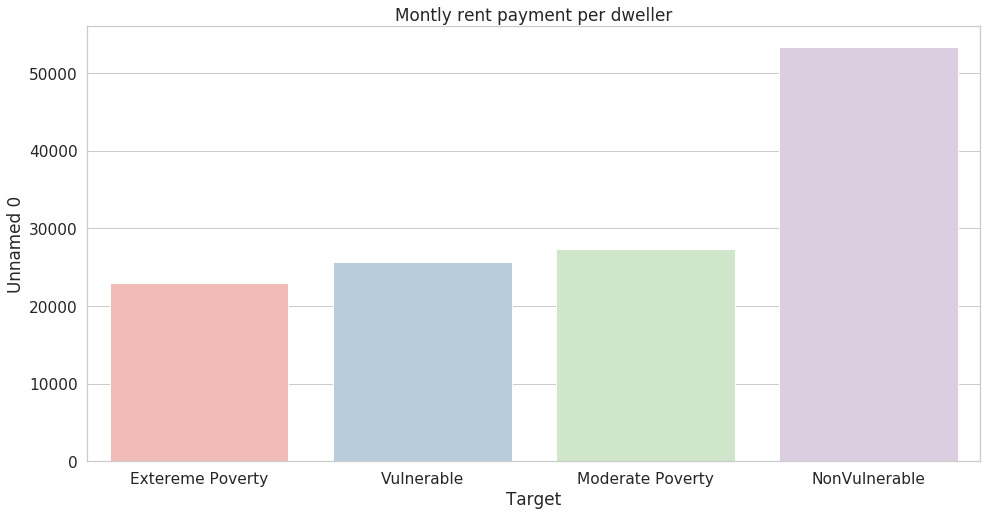

In [75]:
sns.set(style = 'whitegrid', font_scale=1.4)
fig = plt.subplots(figsize=(16, 8))
ax = sns.barplot(x = 'Target', y = 'Unnamed 0', data = rpd, palette='Pastel1',order = ["Extereme Poverty","Vulnerable","Moderate Poverty", "NonVulnerable"], ci = None).set_title('Montly rent payment per dweller')

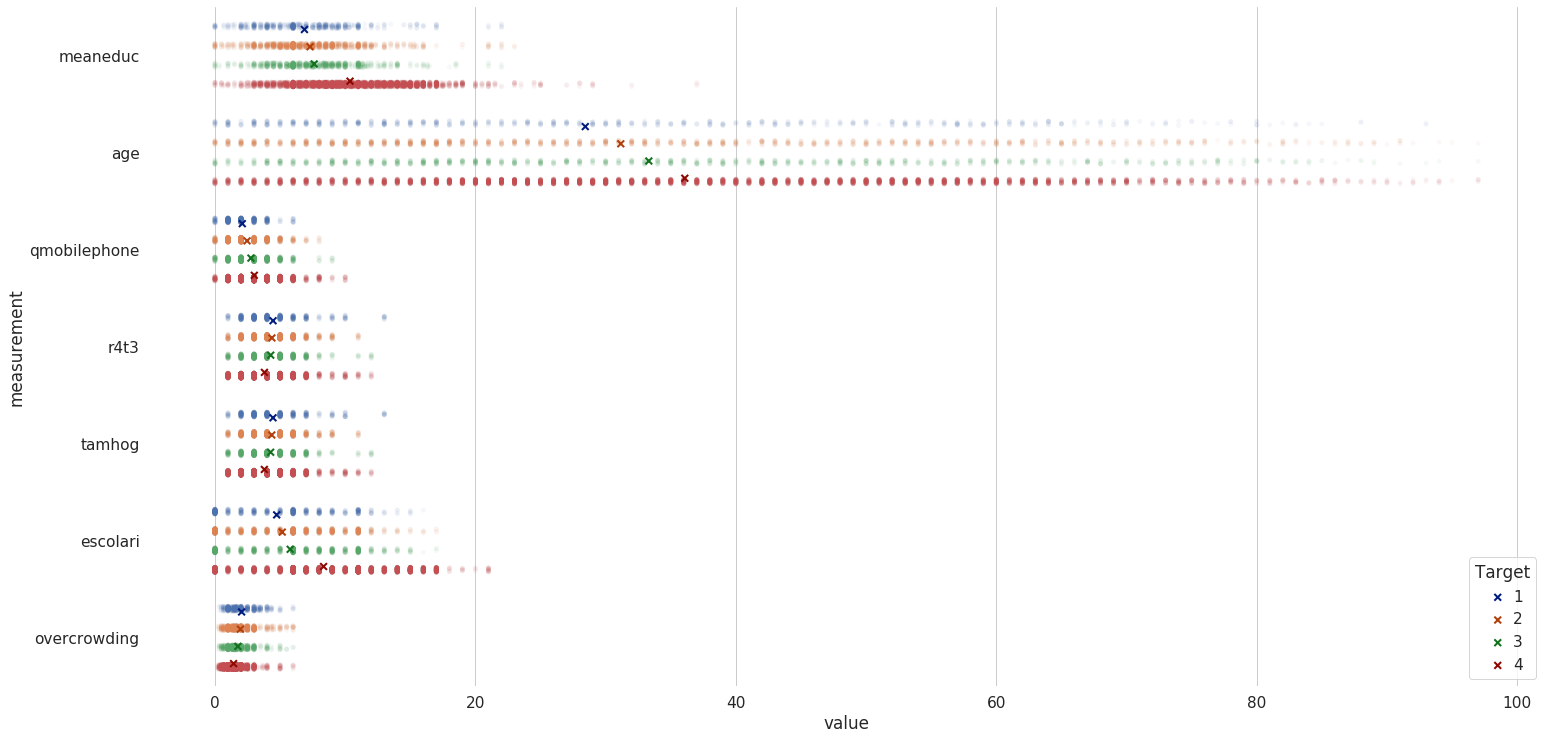

In [76]:
#visualization of feature importance of XGB below


valuez = ['meaneduc', 'age', 'qmobilephone','Target', 'r4t3', 'tamhog', 'escolari', 'overcrowding']
tra = pd.melt(train[valuez], "Target", var_name="measurement")
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)
sns.stripplot(x="value", y="measurement", hue="Target",
              data=tra, dodge=True, jitter=True,
              alpha=.05, zorder=1)
sns.pointplot(x="value", y="measurement", hue="Target",
              data=tra, dodge=.532, join=False, palette="dark",
              markers="x", scale=1, ci=None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title="Target",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=1, frameon=True)


# Part 2. Models

Let's build a **basic XGBoost model** and take a glance at feature importance 

In [77]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [78]:
y = train['Target']
train = train.drop(['Id', 'Target'] ,axis = 1)
train = train.select_dtypes(exclude=['object'])
test = test.drop('Id',axis = 1)
test = test.select_dtypes(exclude=['object'])

In [79]:
y.value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

here we have a deal with skewed classes, that's why we need to use at least stratification in splitting data

In [80]:
y = y - 1
X_train, X_test, y_train, y_test = train_test_split(train, y, stratify = y, test_size = 0.3, random_state = 666)

In [81]:
y.value_counts()

3    5996
1    1597
2    1209
0     755
Name: Target, dtype: int64

In [82]:
from sklearn.metrics import f1_score
def evaluate_macroF1(true_value, predictions):  
    pred_labels = predictions.reshape(len(np.unique(true_value)),-1).argmax(axis=0)
    f1 = f1_score(true_value, pred_labels, average='macro')
    return ('macroF1', f1, True) 
params = {
        "objective" : "multi:softmax",
        "metric" : evaluate_macroF1,
        "n_estimators": 100,
        'max_depth' : 9,
        "learning_rate" : 0.23941,
        'max_delta_step': 2,
        'min_child_weight': 9,
        'subsample': 0.72414,
        "seed": 666,
        'num_class': 4,
        'silent': True
    }
xgbtrain = xgb.DMatrix(X_train, label=y_train)
xgbval = xgb.DMatrix(X_test, label=y_test)


watchlist = [(xgbtrain, 'train'), (xgbval, 'valid')]
evals_result = {}
model = xgb.train(params, xgbtrain, 5000, 
                     watchlist,
                    early_stopping_rounds=150, verbose_eval=100)
#we don't need these for now
#xgbtest = xgb.DMatrix(test)
#p_test = model.predict(xgbtest, ntree_limit=model.best_ntree_limit)

#p_test = p_test + 1

/home/kumar/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-merror:0.127074	valid-merror:0.144003
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 150 rounds.
[100]	train-merror:0.001046	valid-merror:0.049163
[200]	train-merror:0	valid-merror:0.045676
[300]	train-merror:0	valid-merror:0.043933
[400]	train-merror:0	valid-merror:0.042887
[500]	train-merror:0	valid-merror:0.044282
Stopping. Best iteration:
[358]	train-merror:0	valid-merror:0.041841



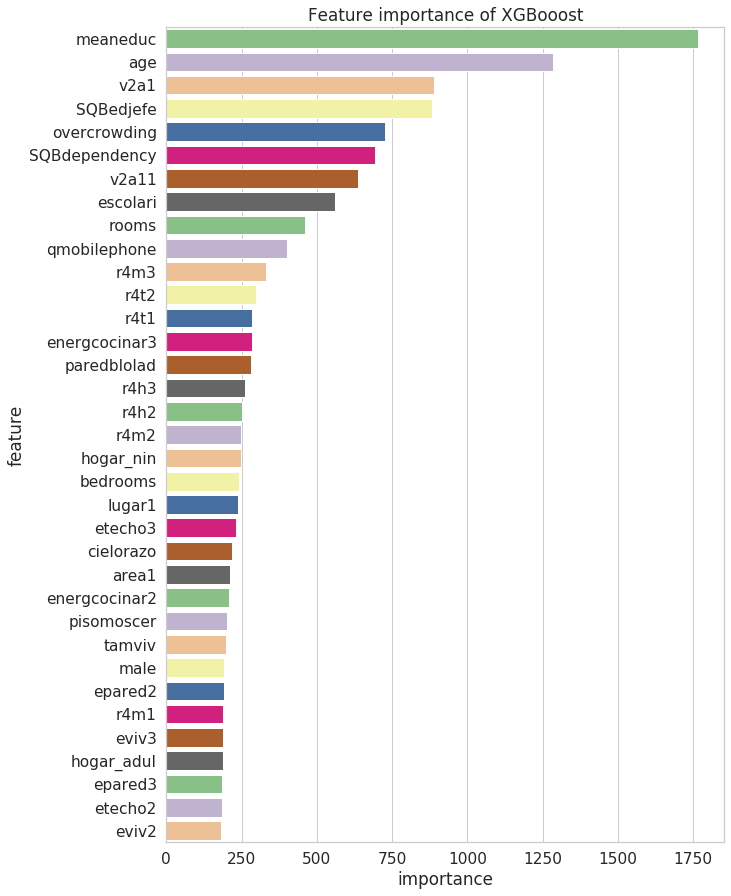

In [83]:
xgb_fimp=pd.DataFrame(list(model.get_fscore().items()),columns=['feature','importance']).sort_values('importance', ascending=False)
xgb_fimp1 = xgb_fimp.iloc[0:35]

sns.set(style = 'whitegrid', font_scale=1.4)
fig = plt.subplots(figsize=(10, 15))
ax = sns.barplot(x = 'importance', y = 'feature', data = xgb_fimp1,palette='Accent', ci = None).set_title('Feature importance of XGBooost')

According to the results, the main feature xgboost extracts is mean education. Then, we observe age, years of education of male head of household squared, overcrowding. 

In [84]:
from sklearn.metrics import classification_report
Xgb_test = xgb.DMatrix(X_test)
y_pred = model.predict(Xgb_test, ntree_limit=model.best_ntree_limit)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       227
           1       0.92      0.88      0.90       479
           2       0.89      0.86      0.87       363
           3       0.98      1.00      0.99      1799

    accuracy                           0.96      2868
   macro avg       0.94      0.93      0.93      2868
weighted avg       0.96      0.96      0.96      2868

